<a href="https://colab.research.google.com/github/jahelsantiago/tensorflow_tutorial/blob/master/Creating_Synthetic_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction and understanding types of series

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def plot_series(time, series, start = 0, end = None,format = "-", label = None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("serie")
  if label:
        plt.legend(fontsize=14)
  plt.grid(True)

## Trend and Seasonality

In [6]:
def trend(time, slope=0):
    return slope * time

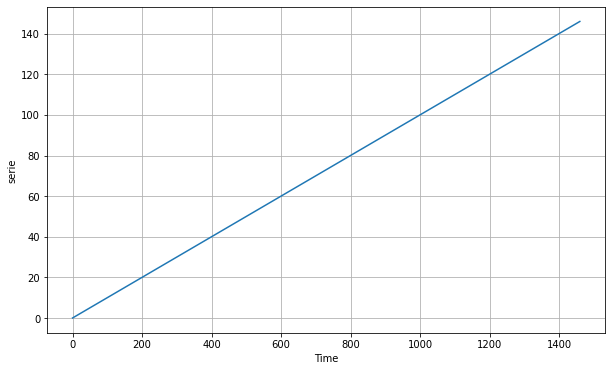

In [7]:
time = np.arange(4*365 + 1)
series = trend(time,0.1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

Generamos una Time Series con Secionalty, o sea que es determinada por ciclos

In [8]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

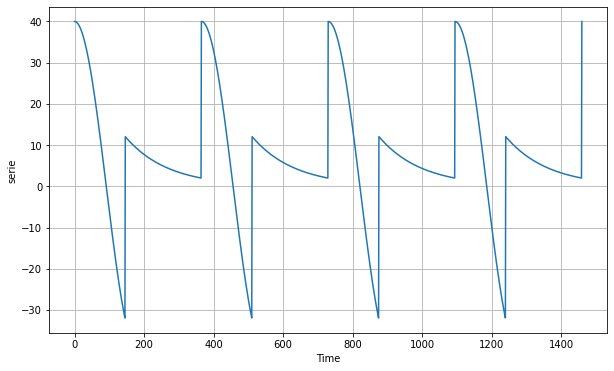

In [9]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Time series with Secionalty and trend

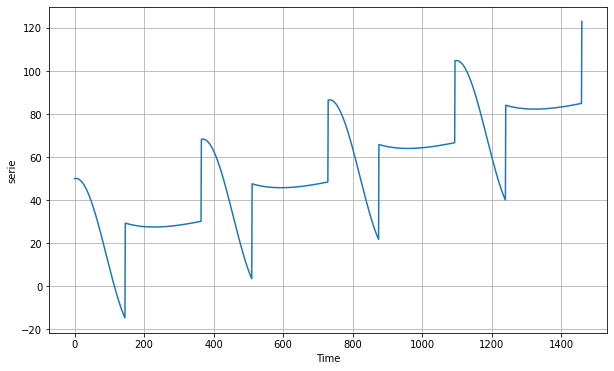

In [10]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Noise, podemos  generar y añadir ruido para hacerlo mas realista

In [11]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

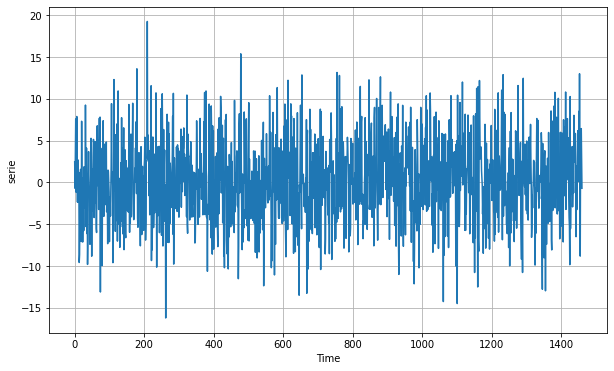

In [12]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

añadimos ruido a la serie

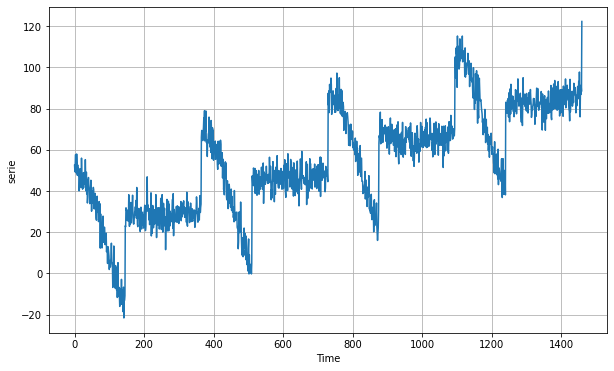

In [11]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Training

### Dividir los datos en train, test y de


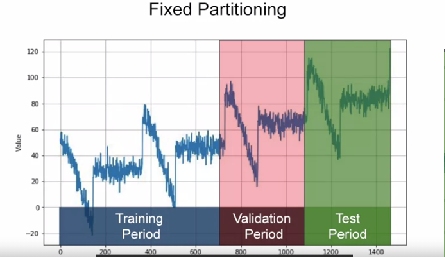

para ello elegimos un punto donde partir los datos y los dividimos en base a eso, **split the array**

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

en la figura podemos ver como se partieron los datos desde  1000

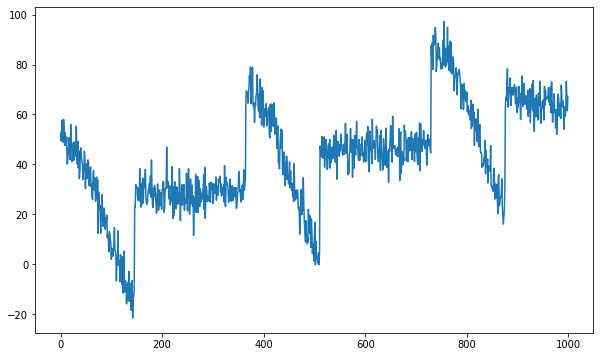

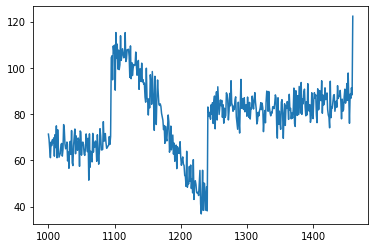

In [13]:
plt.figure(figsize=(10,6))
plt.plot(time_train, x_train)
plt.show()

plt.plot(time_valid, x_valid)
plt.show()

probamos una interpretacion llamada mean avarege forcast, que toma los k anteriores y los computa.

In [20]:
def avarege_forcast(series, k):
  avg = []
  if k > len(series):
    return 
  for i in range(len(series)-k):
    avg.append(series[i:i+k].mean())
  return np.array(avg)


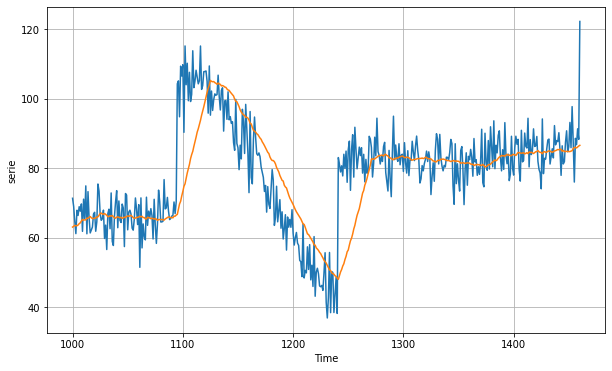

In [28]:
moving_avg = avarege_forcast(series, 30)[split_time - 30:] #usamos la serie original y la dividimos en donde inicia la validation

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [33]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.67456651431165
7.142418570620879


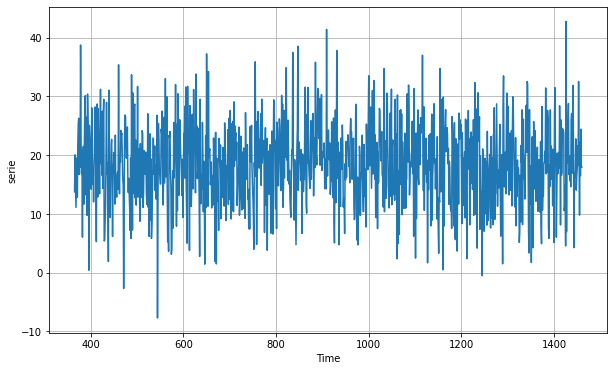

In [37]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

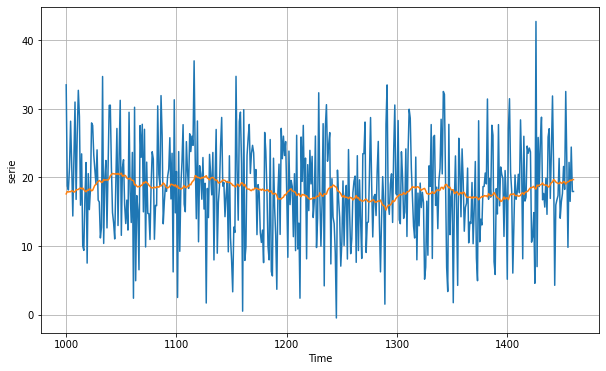

In [46]:
diff_moving_avg = avarege_forcast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()


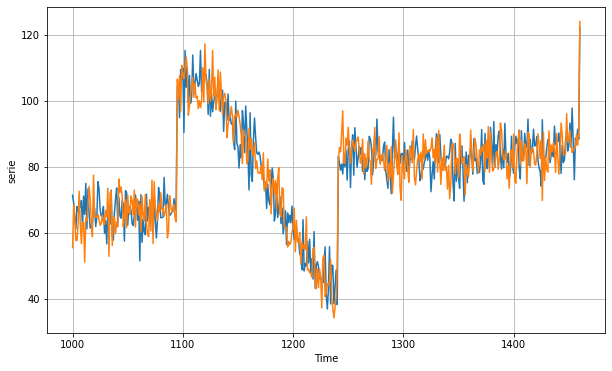

In [47]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [49]:
print(keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97365999969187
5.839310562995895


# Prap

# preparing features and labels

In [1]:
import numpy as np
import tensorflow as tf

In [49]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [50]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [57]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [55]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window_dataset in dataset:
  print(window_dataset)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64)
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64)
tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int64)
tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int64)
tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int64)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64)


In [60]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.shuffle(10)
for window_dataset in dataset:
  print(window_dataset)

tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64)
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64)
tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int64)
tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int64)
tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int64)
tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int64)


In [64]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.shuffle(10)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
  print("x", x.numpy())
  print("y", y.numpy())

x [2 3 4 5]
y [6]
x [1 2 3 4]
y [5]
x [3 4 5 6]
y [7]
x [0 1 2 3]
y [4]
x [4 5 6 7]
y [8]
x [5 6 7 8]
y [9]


In [66]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.shuffle(10)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
  print("x", x.numpy())
  print("y", y.numpy())

x [[1 2 3 4]
 [0 1 2 3]]
y [[5]
 [4]]
x [[5 6 7 8]
 [2 3 4 5]]
y [[9]
 [6]]
x [[3 4 5 6]
 [4 5 6 7]]
y [[7]
 [8]]


# Simple model

In [40]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [41]:
def generate_window_dataset(series,window_size, bachsize, shufflebuffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, 1, 1, True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))  
  dataset = dataset.shuffle(shufflebuffer).map(lambda window : (window[:-1], window[-1:]))
  dataset = dataset.batch(bachsize)
  return dataset

In [42]:
dataset =generate_window_dataset(x_train, window_size, batchsize, shufflebuffer)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(1e-6, momentum=0.9))
model.fit(dataset, epochs = 100, verbose = 0)

print("layer weights {}".format(l0.get_weights()))

<BatchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
layer weights [array([[-8.7981662e-03],
       [-4.0238742e-02],
       [ 4.5012328e-04],
       [ 1.6133167e-02],
       [ 5.0538007e-02],
       [ 1.0944008e-03],
       [-7.1026906e-02],
       [ 4.6218563e-02],
       [ 3.4119669e-02],
       [-4.0168293e-02],
       [-3.1190632e-02],
       [-6.5674232e-03],
       [ 3.9319720e-02],
       [ 3.2670420e-02],
       [-7.7180833e-02],
       [ 9.9040739e-02],
       [ 1.1862373e-01],
       [ 9.0974234e-02],
       [ 2.1165301e-01],
       [ 5.0334775e-01]], dtype=float32), array([0.01165606], dtype=float32)]


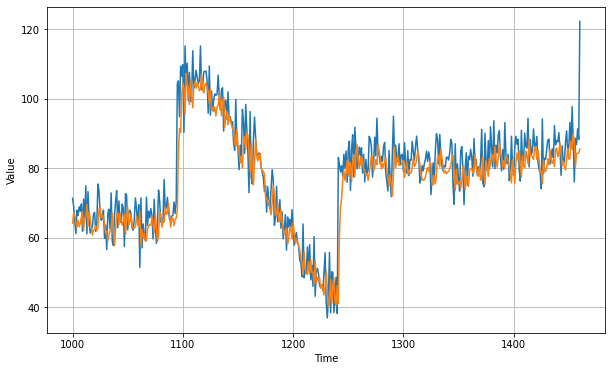

In [43]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
tf.metrics.mean_absolute_error(x_valid, results).numpy()

5.2745852